In [152]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
from dotenv import load_dotenv

# Import Utility Functions
from collab_env.data.file_utils import expand_path, get_project_root
from collab_env.data.gcs_utils import GCSClient

from collab_env.alignment import align

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup API keys

In [2]:
# Load environment variables from .env file
load_dotenv()

gerbils_key = os.environ.get("COLLAB_GERBILS_KEY")
data_key = os.environ.get("COLLAB_DATA_KEY")

print(f"Gerbils key: {gerbils_key}")
print(f"Data key: {data_key}")

Gerbils key: /workspace/api-keys/collab-gerbils-444419-2c6aa9a47bb5.json
Data key: /workspace/api-keys/collab-data-463313-c340ad86b28e.json


### Download an RGB video

In [3]:
CURRENT_PROJECT = "COLLAB_DATA"
PROJECT_KEY = Path(os.environ.get(f"{CURRENT_PROJECT}_KEY"))
PROJECT_ID = "-".join(PROJECT_KEY.stem.split("-")[:-1])

# Connect to GCS
gcs_client = GCSClient(
    project_id=PROJECT_ID,
    credentials_path=expand_path(PROJECT_KEY.as_posix(), get_project_root()),
)

2025-08-05 01:28:03.996 | INFO     | collab_env.data.gcs_utils:__init__:34 - Using credentials from /workspace/api-keys/collab-data-463313-c340ad86b28e.json
2025-08-05 01:28:04.011 | INFO     | collab_env.data.gcs_utils:__init__:40 - Using project collab-data-463313


Find all buckets and grab the videos for the desired session

In [4]:
CURRENT_SESSION = "2024_02_06"
CURRENT_BUCKET = gcs_client.list_buckets()[1]
DTYPE = 'processed'

assert DTYPE in CURRENT_BUCKET, "Current bucket is not the processed bucket"

# Grab the aligned frames for the current session
current_session_dir = gcs_client.glob(f"{CURRENT_BUCKET}/{CURRENT_SESSION}*")[0]

# Set the current output directory
local_out_dir = get_project_root() / "data" / current_session_dir

Download aligned files and splat environment

In [5]:
# Download aligned frames and environment directories
for dir_name in ["aligned_frames", "environment"]:
    gcs_path = f"{current_session_dir}/{dir_name}"
    local_path = local_out_dir / dir_name

    if not local_path.exists():
        gcs_client.download_folder(gcs_path, local_path)

### Now load the video

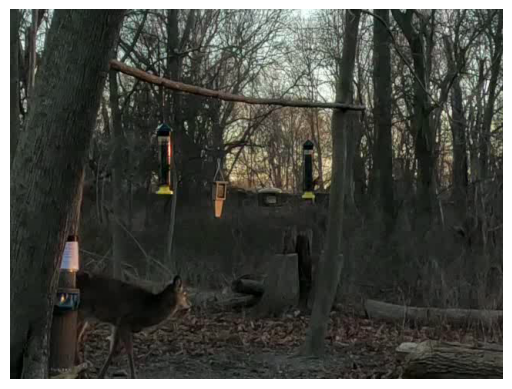

In [6]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

aligned_dir = local_out_dir / "aligned_frames" / "rgb_1"
aligned_fn = aligned_dir / "adjusted_rgb_1.mp4"
cap = cv2.VideoCapture(aligned_fn)

while(cap.isOpened()):
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    break

# Double check the frame is correct
plt.imshow(frame)
plt.axis('off')
plt.show()

Write a frame out

In [7]:
# al = (local_out_dir / "aligned_frames/rgb_1/")
sampled_frames_dir = aligned_dir / "sampled"
os.makedirs(sampled_frames_dir, exist_ok=True)

out_fn = sampled_frames_dir / "0001.png"
frame_out = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
cv2.imwrite(out_fn, frame_out)

True

### Import hloc

In [8]:
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path

from hloc import extract_features, match_features, pairs_from_exhaustive
from hloc.utils.viz import plot_images
from hloc.utils.io import get_keypoints, get_matches
import pycolmap


Configuration for alignment

In [9]:
import collab_env.alignment.align as align

environment_dir = local_out_dir / "environment" # Path to environment directory
preproc_dir = environment_dir / "C0043" / "preproc" # Path to colmap preproc directory
output_dir = local_out_dir / "aligned_splat" # Path to output directory
query_dir = aligned_dir / "sampled" # Path to query directory

Align the new image to the COLMAP fit

In [10]:
poses, logs = align.align_to_splat(
    preproc_dir=preproc_dir,
    query_dir=query_dir,
    output_dir=output_dir,
    localizer_conf={
        'estimation': {'ransac': {'max_error': 50}},
        'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
    },
)

Creating output directory...


[2025/08/05 01:28:21 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Extracting features from queries and matching...
Loaded SuperPoint model


  0%|          | 0/1 [00:00<?, ?it/s]

/opt/conda/envs/collab-env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971132/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,
[2025/08/05 01:28:23 hloc INFO] Finished exporting features.
[2025/08/05 01:28:23 hloc INFO] Found 597 pairs.
[2025/08/05 01:28:23 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


  0%|          | 0/597 [00:00<?, ?it/s]

[2025/08/05 01:29:21 hloc INFO] Finished exporting matches.


Localizing query images...:   0%|          | 0/1 [00:00<?, ?it/s]

### View the mesh

In [148]:
import open3d as o3d

mesh_dir = local_out_dir / "environment" / "C0043" / "rade-features" / "mesh"
mesh_fn = mesh_dir / "Open3dTSDFfusion_mesh.ply"

Load the mesh

In [149]:
mesh = o3d.io.read_triangle_mesh(str(mesh_fn))

mesh = o3d.io.read_triangle_mesh(mesh_fn)
mesh.compute_vertex_normals()
# mesh.transform(mesh_transform)

mesh_points = np.asarray(mesh.vertices)
mesh_colors = np.asarray(mesh.vertex_colors) * 255

Map to mesh alignment

Camera Intrinsics:
  Resolution: 640 x 480
  Focal lengths: fx=1109.8, fy=1109.8
  Principal point: cx=320.0, cy=240.0
  Field of view: 32.2° (horizontal), 24.4° (vertical)
  Aspect ratio: 1.333


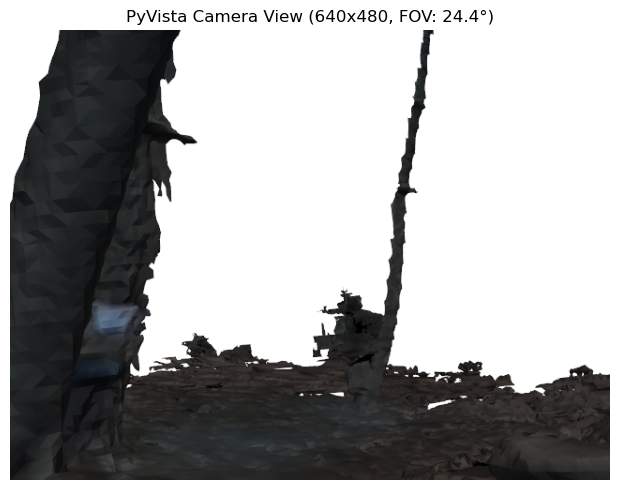

In [159]:
camera_params = align.align_to_mesh(preproc_dir, mesh_dir, poses[0])

_ = align.pyvista_camera_view_with_intrinsics(mesh_fn, camera_params)